In [ ]:
## load csv file from cloud drive
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/"  # this is your drive

Mounted at /content/drive/


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313504 sha256=3171f54cb74ab9c19ab4f3fa97dce302abc0ae93c1d5cfc37fd14e2b9e8d31c1
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from collections import Counter

In [ ]:
data = pd.read_csv(data_path + 'data_standard.csv')
texts = data['text'].tolist()
labels = data['sentiment'].tolist()

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Divide the training set and testing set
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
def load_word2vec_format(file_path):
    # Load. vec file and return word vector dictionary
    word_vectors = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector
    return word_vectors

ft = load_word2vec_format(data_path + 'wiki-news-300d-1M-subword.vec')


In [ ]:
# Text encoding
def encode_texts(texts, ft, max_len=128):
    encoded_texts = []
    for text in texts:
        words = text.split()
        vectors = [ft[word] if word in ft else np.zeros(300) for word in words]
        if len(vectors) < max_len:
            vectors += [np.zeros(300)] * (max_len - len(vectors))
        else:
            vectors = vectors[:max_len]
        encoded_texts.append(np.array(vectors))
    return np.array(encoded_texts)

max_len = 128
train_texts_encoded = encode_texts(train_texts, ft, max_len)
test_texts_encoded = encode_texts(test_texts, ft, max_len)

In [ ]:
# Custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = TextDataset(train_texts_encoded, train_labels)
test_dataset = TextDataset(test_texts_encoded, test_labels)

# Data Loader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        output, (hidden, cell) = self.lstm(text)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

# Set model parameters
input_dim = 300
hidden_dim = 128
output_dim = 3
n_layers = 2
bidirectional = True
dropout = 0.5

model = LSTMModel(input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training function
def train_model(model, optimizer, criterion, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Test set evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for texts, labels in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies


In [ ]:
# Train the model with 40 rounds

num_epochs = 40
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, optimizer, criterion, num_epochs)


Epoch [1/40], Train Loss: 1.0853, Train Acc: 0.4135, Test Loss: 1.1196, Test Acc: 0.3000
Epoch [2/40], Train Loss: 1.0759, Train Acc: 0.4261, Test Loss: 1.1243, Test Acc: 0.3000
Epoch [3/40], Train Loss: 1.0811, Train Acc: 0.4236, Test Loss: 1.1171, Test Acc: 0.3000
Epoch [4/40], Train Loss: 1.0709, Train Acc: 0.4261, Test Loss: 1.1165, Test Acc: 0.3100
Epoch [5/40], Train Loss: 1.0669, Train Acc: 0.4236, Test Loss: 1.1301, Test Acc: 0.3000
Epoch [6/40], Train Loss: 1.0632, Train Acc: 0.4286, Test Loss: 1.1329, Test Acc: 0.2800
Epoch [7/40], Train Loss: 1.0591, Train Acc: 0.4361, Test Loss: 1.1060, Test Acc: 0.3000
Epoch [8/40], Train Loss: 1.0305, Train Acc: 0.4937, Test Loss: 1.1212, Test Acc: 0.3400
Epoch [9/40], Train Loss: 0.9761, Train Acc: 0.5439, Test Loss: 1.0680, Test Acc: 0.4100
Epoch [10/40], Train Loss: 0.9422, Train Acc: 0.5489, Test Loss: 1.0229, Test Acc: 0.4800
Epoch [11/40], Train Loss: 0.8719, Train Acc: 0.6291, Test Loss: 1.0001, Test Acc: 0.5400
Epoch [12/40], Trai

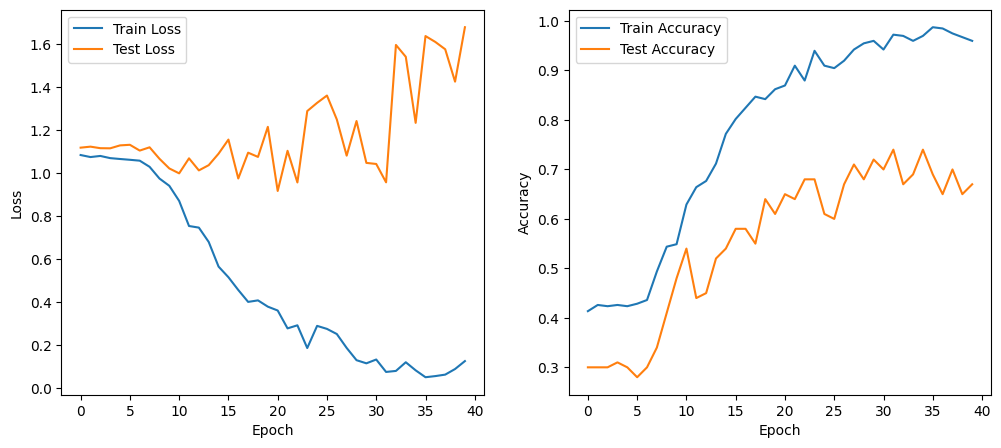

In [ ]:
# Draw loss and accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluation model
def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

evaluate_model(model, test_loader)

Test Accuracy: 0.6700
Test Precision: 0.6697
Test Recall: 0.6718
Test F1 Score: 0.6703
